In [1]:
import os
import sys

import cartopy
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xarray as xr
import xesmf as xe
import xcdat as xc
import xsearch as xs
import xskillscore as xscore

from glob import glob 
from scipy.stats import linregress
from typing import List, Tuple, Dict, Union, Optional, Any, Callable, Iterable, Sequence, cast

# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 

In [2]:
# SST_PRODUCTS = ["ERA5", "NOAA", "COBE", "COBE2", "NOAA-OISST-v2.1", "NOAA-OISST-v2.0", "HadISST-1.1", "HadSST4", "PCMDI-AMIP-1-1-9"]
SST_PRODUCTS = ["PCMDI-AMIP-1-1-9", "ERA5", "NOAA-ERSSTv5", "COBE", "NOAA-OISST-v2.1"]

In [3]:
# SANITY CHECK Plotting
def global_plot(data, lon, lat, cmap, pvalues=None, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = "", SAVE_PATH: str = ""):
    # plot map of global data with central longitude 180
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree(central_longitude=180))
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    # East Pacific South America
    # bound_region(ax, lons=(-105, -70), lats=(-40, -10), color="black")
    # Southern Ocean
    # bound_region(ax, lons=(-180, -75), lats=(-70, -50), color="black")
    # East Pacific
    # bound_region(ax, lons=(-135, -80), lats=(-5, 5), color="black")
    # West Pacific
    # bound_region(ax, lons=(110, 165), lats=(-5, 5), color="black")
    
    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    # Add Stippling
    if pvalues is not None:
        ax.contourf(
            lon, lat, pvalues,
            colors='none',
            levels=[0, .05, 1],
            hatches=['...', None,],
            transform=ccrs.PlateCarree(), 
        )
        
    ax.coastlines()
    ax.set_global()
    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)
    
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())
    # Add a horizontal colorbar
    cbar = plt.colorbar(img, orientation='horizontal')
    cbar.set_label(cbar_label, fontsize=14)
    plt.savefig(f"manuscript_figures/SI_Figures/Figure_SX_Obs_SST_Trends/{right_title}_gray.png", dpi=600, bbox_inches='tight')

def bound_region(ax, lons, lats, color):
    lon_min, lon_max = lons
    lat_min, lat_max = lats

    # Draw a black bounding box around region
    ax.plot(
        [lon_min, lon_min, lon_max, lon_max, lon_min], 
        [lat_min, lat_max, lat_max, lat_min, lat_min], 
        color=color, linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )


def get_triangle(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[1]: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:nlats, i] = np.full((nlats), np.nan) 
        
        jold = j
    
    return ctos


def get_triangle_mean(tos, latmin, latmax, lonmin, lonmax, RES):
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    ntime, nlat, nlon = tos.shape
    ctos = tos.sel(longitude=slice(lonmin, lonmax), latitude=slice(latmin, latmax))

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == ctos.shape[2]: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
            
        nlats = int(len(latcoords) - j) # nlats below diag
        ctos[:,:nlats, i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
     
    return ctos

In [4]:
def remove_land_full(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.longitude, ds.latitude)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land

def fix_coords(data, include_T=True):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    if include_T: data = data.bounds.add_bounds("T")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data


# Compute Obs SST Trends

In [5]:
def load_sst(product_name="ERA5"):
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)
    
    # USE A COMMON TIME PERIOD 
    start_time = "1982-01-01"
    end_time = "2022-12-31"

    ###### PREPROCESSING ######
    if product_name == "ERA5":
        ds = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc").rename({"skt": "sst"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-ERSSTv5":
        ds = xc.open_dataset("data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "COBE":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/COBE/sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    elif product_name == "COBE2":
        ds = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc").sel(time=slice(start_time, end_time))
        ds = ds.rename({"lon": "longitude", "lat": "latitude"})
        
    elif product_name == "NOAA-OISST-v2.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2.1/sst.mon.mean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "NOAA-OISST-v2.0":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/NOAA-OISST-v2/sst.mnmean.nc")
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
        
    elif product_name == "HadISST-1.1":
        ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST_sst.nc").sel(time=slice(start_time, end_time))

    # elif product_name == "HadISST-2.2":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST-2-2-0-0-0.nc").rename({"tos": "sst"})
    #     ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # elif product_name == "HadISST-2.3":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadISST/HadISST.2.3.0.c_ensemble_member_001.nc").rename({"tos": "sst"})
    #     ds = ds.rename({"lon": "longitude", "lat": "latitude"})

    # elif product_name == "HadSST4":
    #     ds = xc.open_dataset("/p/user_pub/climate_work/zelinka1/HadSST/HadSST.4.0.1.0_median.nc").rename({"tos": "sst"}).sel(time=slice(start_time, end_time))

    elif product_name == "PCMDI-AMIP-1-1-9":
        ds = xc.open_dataset("/p/user_pub/work/input4MIPs/CMIP6Plus/CMIP/PCMDI/PCMDI-AMIP-1-1-9/ocean/mon/tos/gn/v20230512/tos_input4MIPs_SSTsAndSeaIce_CMIP_PCMDI-AMIP-1-1-9_gn_187001-202212.nc").rename({"tos": "sst"})
        ds = ds.rename({"lon": "longitude", "lat": "latitude"}).sel(time=slice(start_time, end_time))
    
    ###### PREPROCESSING ######
    ds = remove_land_full(ds, var="sst").rename("sst").to_dataset()
    # print(ds)
    ds = fix_coords(ds, include_T=True)
    ds = ds.reindex(latitude=list(reversed(ds.latitude)))
    # Calculate Anomalies
    ds = ds.temporal.departures("sst", "month")
    # Regrid to 2.5x2.5 degree grid
    ds = ds.regridder.horizontal("sst", output_grid, tool='xesmf', method='bilinear')
    ds = ds.rename({"lon": "longitude", "lat": "latitude"})
    # print(ds)

    # Get SST Trend in Triangular Region
    latmin, latmax = -38.75, -1.25
    lonmin, lonmax = -178.75, -71.25
    RES = 2.5
    ept = get_triangle_mean(ds["sst"].copy(), latmin, latmax, lonmin, lonmax, RES)
    ept_mean  = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]
    # EPT Trend
    time_idx = xr.DataArray(np.arange(len(ds.time)), dims=("time"))
    # reg = linregress(time_idx, ept_mean)
    ept_mean_trend = xscore.linslope(time_idx, ept_mean, dim="time")*12*30


    # Get SST Trends
    time_idx = xr.DataArray(np.arange(len(ds.time)), dims=("time"))
    ds_trends = xscore.linslope(time_idx, ds["sst"], dim="time")*12*30
    ds_sig = xscore.pearson_r_p_value(time_idx, ds["sst"], dim="time")

    # Get SST Trend in Triangular Region
    ept = get_triangle(ds_trends.copy(), latmin, latmax, lonmin, lonmax, RES)
    EPT_mean_trend = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]
    print(EPT_mean_trend)

    # Sanity Check - Plot ERA5 SST Trends
    global_plot(
        ds_trends,
        ds_trends.longitude, 
        ds_trends.latitude, 
        pvalues=ds_sig, 
        levels=np.arange(-1,1.1,.1), 
        cmap="RdBu_r", 
        left_title=f"{np.around(ept_mean_trend.values, 3)}", 
        right_title=f"{product_name}",
        cbar_label=r"$K/30yr$",
        SAVE_PATH="",
    )

    return ds_trends, ds_sig, ept_mean_trend, ds

For each latitude step of 2.5 degrees, longitude step is 7.5


2024-05-06 15:44:27,809 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'tos' ()>
array(-0.30252565)
For each latitude step of 2.5 degrees, longitude step is 7.5


2024-05-06 15:44:33,548 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'tos' ()>
array(-0.248169)


2024-05-06 15:44:36,715 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


2024-05-06 15:44:40,187 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'tos' ()>
array(-0.26244152)


2024-05-06 15:44:42,392 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


For each latitude step of 2.5 degrees, longitude step is 7.5


2024-05-06 15:44:50,591 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'tos' ()>
array(-0.14976065)
For each latitude step of 2.5 degrees, longitude step is 7.5


2024-05-06 15:47:08,929 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray 'tos' ()>
array(-0.13896384)


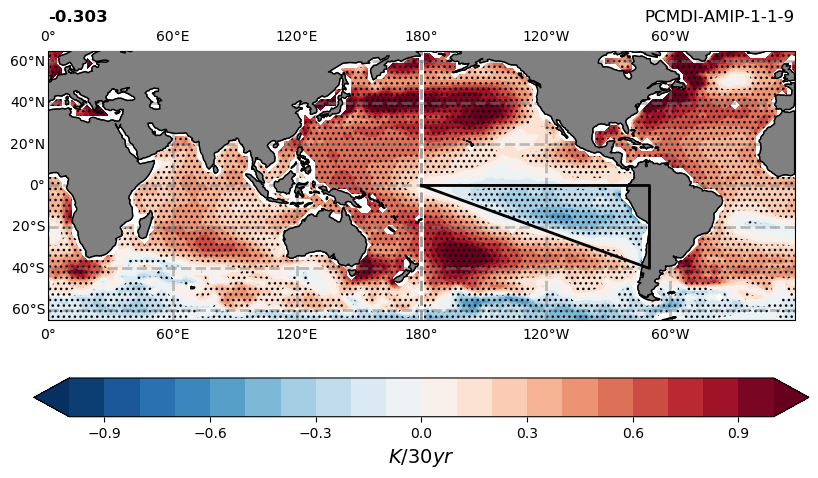

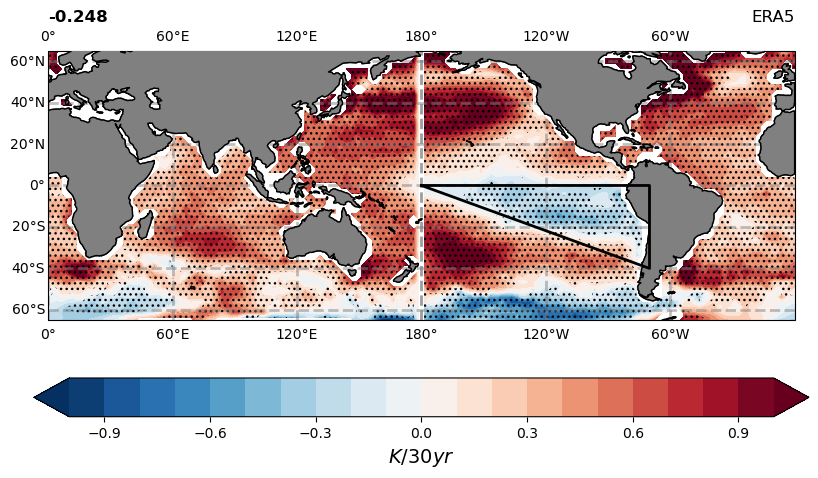

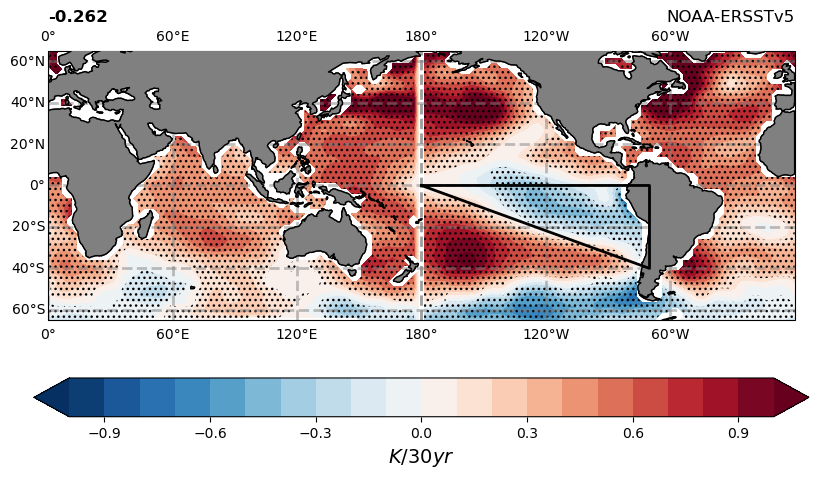

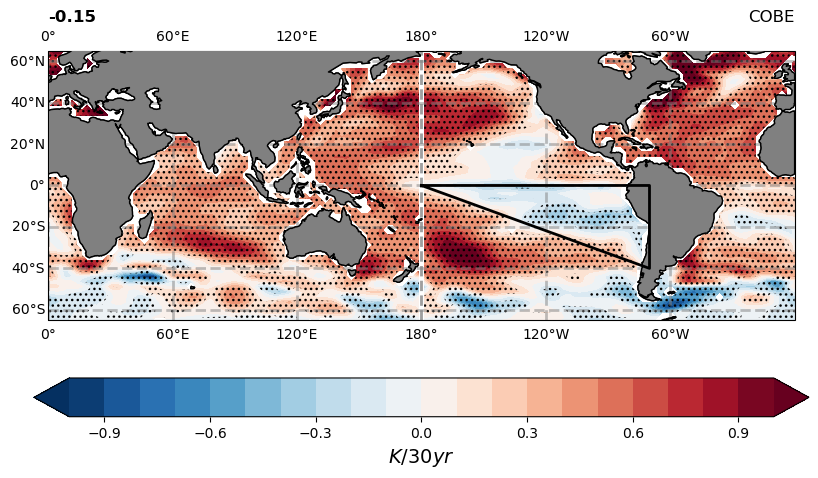

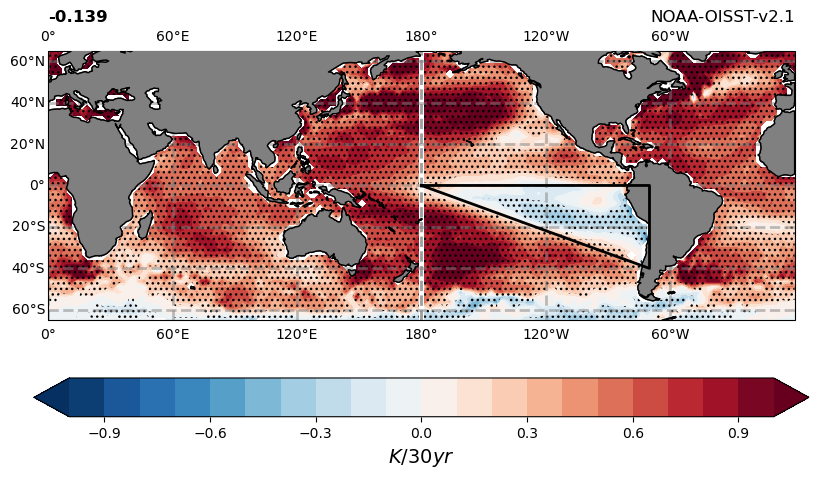

In [6]:
""" 
    Load SST Trends for each product and save to netcdf
"""
for i, sst_product in enumerate(SST_PRODUCTS): 
    trends, sig, mean, ssts = load_sst(sst_product)
    # print(ssts)
    # Merge Datasets
    ds = xr.merge([
        trends.rename("trends").to_dataset(),
        sig.rename("pvalues").to_dataset(),
        mean.rename("EPT_Mean").to_dataset(),
        ssts,
    ])
    # break
    # Save Datasets
    # ds.to_netcdf(f"data/obs/{sst_product}_sst_trends.nc")

In [8]:
sst_ept_mean_trends = np.array([a.values for a in sst_ept_mean.values()])
print(np.mean(sst_ept_mean_trends), sst_ept_mean_trends)

# np.mean([-0.30995762, -0.30437485, -0.21955642, -0.26466877, -0.30762401, -0.03324401, -0.13590471, -0.24306433])

-0.25930445921074835 [-0.30995762 -0.30437485 -0.24953692 -0.26466877 -0.30762401 -0.13590471
 -0.24306433]


## Sanity Check SST

2023-08-23 15:04:20,190 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


For each latitude step of 2.5 degrees, longitude step is 7.5
<xarray.DataArray (latitude: 19, longitude: 54)>
array([[ 1.90507039e-03,  1.48479773e-03,  2.19576826e-03, ...,
        -2.53449736e-04, -1.73712776e-03,             nan],
       [ 1.15427820e-03,  1.92367206e-03,  1.83455536e-03, ...,
        -5.61894537e-04, -6.88950062e-04,             nan],
       [ 1.79484969e-03,  1.97094802e-03,  1.98399150e-03, ...,
        -1.00110074e-03, -4.46387732e-04, -2.18059740e-03],
       ...,
       [ 3.52934177e-04,  1.83412803e-04,  1.70951063e-04, ...,
                    nan,             nan,             nan],
       [-6.88118637e-05, -3.84437866e-05, -2.13521237e-04, ...,
                    nan,             nan,             nan],
       [-8.34016406e-05, -2.00467018e-04, -1.42950260e-04, ...,
                    nan,             nan,             nan]])
Coordinates:
  * latitude   (latitude) float32 -38.0 -36.0 -34.0 -32.0 ... -6.0 -4.0 -2.0
  * longitude  (longitude) float32 -178.0 -

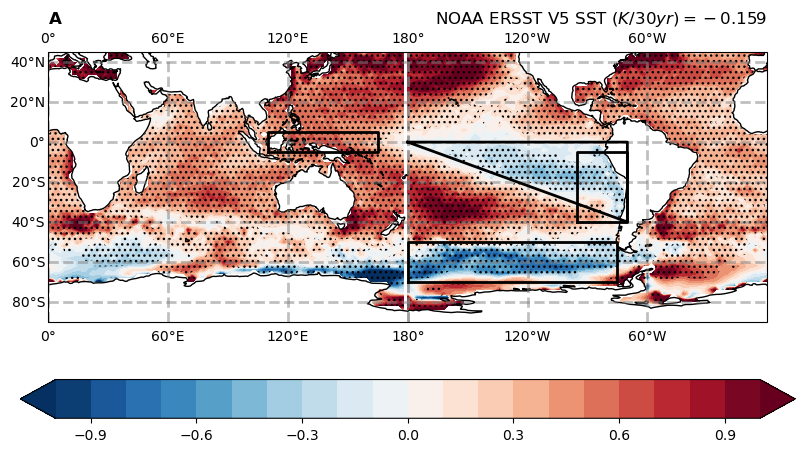

In [69]:
era5 = xc.open_dataset("data/obs/ts_mon_ERA5_197901-202212.nc")
# era5 = xc.open_dataset("data/obs/COBE2.sst.mon.mean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# era5 = xc.open_dataset("data/obs/NOAA_ERSST_V5_sst.mnmean.nc").sel(time=slice("1979-01-01", "2022-12-31"))
# era5 = era5.rename({"lon": "longitude", "lat": "latitude", "sst": "skt"})

era5 = remove_land_full(era5, var="skt")
era5_ds = fix_coords(era5.to_dataset()) #- 273.15)
era5_ds = era5_ds.temporal.departures("skt", "month")

time_idx = xr.DataArray(np.arange(len(era5_ds.time)), dims=("time"))
era5_trends = xscore.linslope(time_idx, era5_ds["skt"], dim="time")
era5_sig = xscore.pearson_r_p_value(time_idx, era5_ds["skt"], dim="time")

# Get SST Trend in Triangular Region
latmin, latmax = -38.75, -1.25
lonmin, lonmax = -178.75, -71.25
RES = 2.5
    
era5_reindex = era5_trends.reindex(latitude=list(reversed(era5_trends.latitude)))
ept = get_triangle(era5_reindex, latmin, latmax, lonmin, lonmax, RES)*12*30
EPT_mean_trend = (fix_coords(ept.rename("tos").to_dataset(), include_T=False)).spatial.average("tos")["tos"]

# Plot ERA5 SST Trends
global_plot(
    era5_trends*12*30, 
    era5_trends.longitude, 
    era5_trends.latitude, 
    pvalues=era5_sig, 
    levels=np.arange(-1,1.1,.1), 
    cmap="RdBu_r", 
    left_title="A", 
    right_title=f"NOAA ERSST V5 SST $(K/30yr) = {np.around(EPT_mean_trend.values, 3)}$"
)
# global_plot(era5_trends, era5_trends.longitude, era5_trends.latitude, pvalues=era5_sig, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", left_title="B", right_title="ERA5 $\Delta$SST $(K/30yr)$")

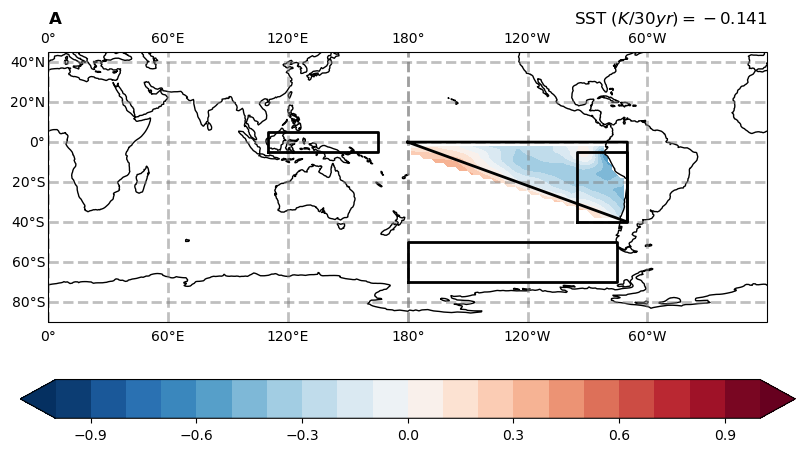

In [38]:

global_plot(
    data=ept,
    lat=ept.lat,
    lon=ept.lon,
    pvalues=None, 
    levels=np.arange(-1, 1.1, .1),
    cmap="RdBu_r",
    left_title="A", 
    right_title=f" SST $(K/30yr) = {np.around(EPT_mean_trend.values, 3)}$"
)

In [16]:
era5_ds = fix_coords(era5.to_dataset() - 273.15)
era5_ds = era5_ds.temporal.departures("skt", "month")


era5_westPacificHoell = era5_ds.sel(longitude=slice(130, 150), latitude=slice(10, 0)).spatial.average("skt")["skt"]
era5_eastPacificObs = era5_ds.sel(longitude=slice(-180, -80), latitude=slice(0, -10)).spatial.average("skt")["skt"]
era5_WE = era5_westPacificHoell - era5_eastPacificObs
    

era5_westPacificWills = era5_ds.sel(longitude=slice(110, 165), latitude=slice(5, -5)).spatial.average("skt")["skt"]
era5_eastPacificWills = era5_ds.sel(longitude=slice(-135, -80), latitude=slice(5, -5)).spatial.average("skt")["skt"]
era5_WE = era5_westPacificWills - era5_eastPacificWills

era5_eastPacificSA = era5_ds.sel(longitude=slice(-95, -70), latitude=slice(-5, -40)).spatial.average("skt")["skt"]

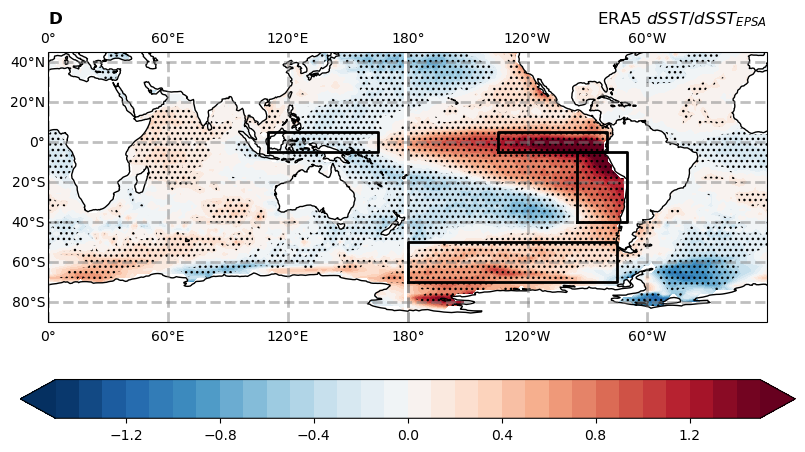

In [9]:
dsst_dsstWE = xscore.linslope(era5_eastPacificSA, era5_ds["skt"], dim="time", skipna=True)
dsst_dsstWE_pvalue = xscore.pearson_r_p_value(era5_eastPacificSA, era5_ds["skt"], dim="time", skipna=True)
global_plot(dsst_dsstWE, dsst_dsstWE.longitude, dsst_dsstWE.latitude, pvalues=dsst_dsstWE_pvalue, levels=np.arange(-1.5,1.6, .1), cmap="RdBu_r", left_title="D", right_title=r"ERA5 $dSST/dSST_{EPSA}$")

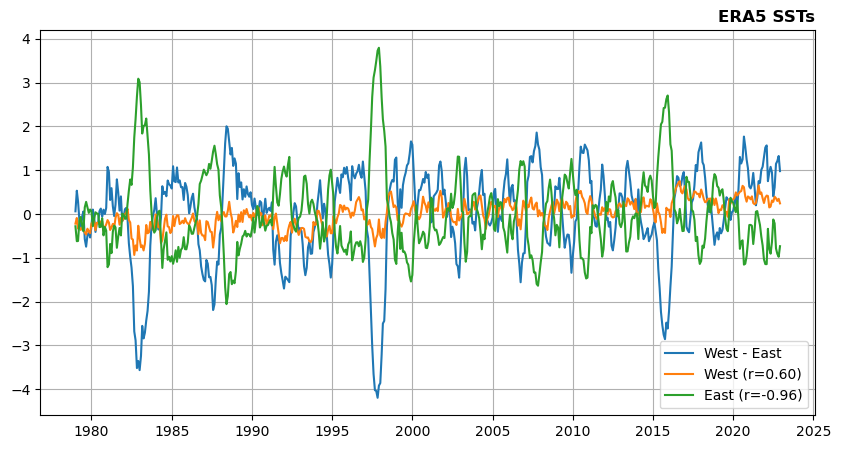

In [56]:
from scipy.stats import linregress

plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_WE, label="West - East")
res = linregress(era5_westPacificWills, era5_WE)
plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_westPacificWills, label=f"West (r={res.rvalue:.2f})")
res = linregress(era5_eastPacificWills, era5_WE)
plt.plot(np.arange("1979-01", "2023-01", dtype="datetime64[M]"), era5_eastPacificWills, label=f"East (r={res.rvalue:.2f})")
plt.legend()
plt.grid()
plt.title("ERA5 SSTs", fontweight="bold", loc="right")
# set siz
fig = plt.gcf()
fig.set_size_inches(10, 5)

# Compute SWCRE Trends and Calculate SWCF

In [7]:
def remove_land(ds, var="skt"):
    ds = xc.swap_lon_axis(ds, to=(-180, 180))
    from global_land_mask import globe
    # Set land to NaN
    lon_grid,lat_grid = np.meshgrid(ds.lon, ds.lat)
    globe_land_mask = globe.is_land(lat_grid,lon_grid)
    globe_land_mask_nd = np.tile(globe_land_mask,(ds[var].shape[0],1,1))
    ds_no_land = xr.where(globe_land_mask_nd==True,np.nan,ds[var]) 
    return ds_no_land


In [8]:
ceres_lw = xr.open_dataset("/p/user_pub/climate_work/zelinka1/CERES/CERES_EBAF_Ed4.1_Subset_200003-202111.nc")
ceres_lw

<xarray.Dataset>
Dimensions:                (lon: 360, lat: 180, time: 261)
Coordinates:
  * lon                    (lon) float32 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * lat                    (lat) float32 -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * time                   (time) datetime64[ns] 2000-03-15 ... 2021-11-15
Data variables: (12/24)
    sfc_sw_down_all_mon    (time, lat, lon) float32 ...
    sfc_sw_down_clr_c_mon  (time, lat, lon) float32 ...
    sfc_sw_down_clr_t_mon  (time, lat, lon) float32 ...
    sfc_sw_up_all_mon      (time, lat, lon) float32 ...
    sfc_sw_up_clr_c_mon    (time, lat, lon) float32 ...
    sfc_sw_up_clr_t_mon    (time, lat, lon) float32 ...
    ...                     ...
    sfc_net_tot_all_mon    (time, lat, lon) float32 ...
    sfc_net_tot_clr_c_mon  (time, lat, lon) float32 ...
    sfc_net_tot_clr_t_mon  (time, lat, lon) float32 ...
    sfc_cre_net_sw_mon     (time, lat, lon) float32 ...
    sfc_cre_net_lw_mon     (time, lat, lon) float32 ...
    sfc_cre_net_tot_mon    (time, lat, lon) float32 ...
Attributes:
    title:        CERES EBAF TOA and Surface Fluxes. Monthly Averages and 07/...
    institution:  NASA Langley Research Center
    Conventions:  CF-1.4
    comment:      Climatology from 07/2005 to 06/2015
    version:      Edition 4.1; Release Date June 8, 2021
    DOI:          10.5067/TERRA-AQUA/CERES/EBAF_L3B004.1

In [9]:
def load_ceres_obs(region: str = "toa", flux: str = "swcre"):
    """Load CERES Data depending on region and flux

    Args:
        region (str, optional): _description_. Defaults to "toa".
        flux (str, optional): _description_. Defaults to "swcre".
    """
    # Create dictionary between CMIP naming conventions and CERES naming conventions
    variables = ['clt','rsdt','rsut','rsutcs','rsds','rsus','rsdscs','rsuscs', "rlds", "rldscs", "lwcre-surface", "swcre-surface", "cre-surface"]
    native = ['cldarea_total_daynight_mon','solar_mon','toa_sw_all_mon','toa_sw_clr_t_mon', 'sfc_sw_down_all_mon','sfc_sw_up_all_mon','sfc_sw_down_clr_t_mon','sfc_sw_up_clr_t_mon',
              'sfc_lw_down_all_mon', 'sfc_lw_down_clr_t_mon', 'sfc_cre_net_lw_mon', 'sfc_cre_net_sw_mon', 'sfc_cre_net_tot_mon']

    var_dic=dict(zip(variables,native))

    if region == "toa": 
        ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")

        if flux == "swcre":
            swas = remove_land(ceres, var="toa_sw_all_mon")
            swcs = remove_land(ceres, var="toa_sw_clr_c_mon")
            swcre = swcs - swas # Clear Sky minus All Sky
            return swcre

        if flux == "lwcre":
            lwas = remove_land(ceres, var="toa_lw_all_mon")
            lwcs = remove_land(ceres, var="toa_lw_clr_c_mon")
            lwcre = lwcs - lwas # Clear Sky minus All Sky
            return lwcre
        
        if flux == "cre":
            nas = remove_land(ceres, var="toa_net_all_mon")
            ncs = remove_land(ceres, var="toa_net_clr_c_mon")
            cre = -(ncs - nas) # Clear Sky minus All Sky (These are both incoming/downard fluxes, so we need to flip the sign)
            return cre
    
    if region == "surface":
        ceres = xr.open_mfdataset(["/p/user_pub/climate_work/zelinka1/CERES/CERES_EBAF_Ed4.2_Subset_200003-201412.nc", "/p/user_pub/climate_work/zelinka1/CERES/CERES_EBAF_Ed4.2_Subset_201501-202212.nc"])
        ceres_lw = xr.open_dataset("/p/user_pub/climate_work/zelinka1/CERES/CERES_EBAF_Ed4.1_Subset_200003-202111.nc")

        sw = remove_land(ceres, var=var_dic["rsds"]) - remove_land(ceres, var=var_dic["rsus"]) # Net Downward Shortwave Radiation
        swc = remove_land(ceres, var=var_dic["rsdscs"]) - remove_land(ceres, var=var_dic["rsuscs"])# Net Downward Clear-sky Shortwave Radiation
        swcre = sw - swc # Shortwave Cloud Radiative Effect (Surface Downward)
        # lwcre = remove_land(ceres_lw, var=var_dic["rlds"]) - remove_land(ceres_lw, var=var_dic["rldscs"]) # Longwave Cloud Radiative Effect (Surface Downward)

        if flux == "swcre":
            return swcre

        if flux == "lwcre":
            lwcre = remove_land(ceres_lw, var=var_dic["lwcre-surface"]) # Longwave Cloud Radiative Effect (Surface Downward)
            return lwcre 
        
        if flux == "cre":
            cre = remove_land(ceres_lw, var=var_dic["cre-surface"]) # Longwave Cloud Radiative Effect (Surface Downward)
            return cre

        
# load_ceres_obs(region="surface", flux="lwcre")

In [10]:
def regrid_and_anomalies(cre, cre_name: str = "swcre"):
    ## REGRID SWCRE
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(-178.75, 180, 2.5)
    output_grid = xc.create_grid(lat, lon)

    cre_ds = fix_coords(cre.rename(cre_name).to_dataset())
    cre_regrid = cre_ds.regridder.horizontal(cre_name, output_grid, tool='xesmf', method='bilinear')
    cre_regrid["time"] = np.arange(cre_regrid.time.values[0], np.datetime64(cre_regrid.time.values[-1], 'M') + np.timedelta64(1,'M'), dtype="datetime64[M]")
    cre_regrid = cre_regrid.rename({"lon": "longitude", "lat": "latitude"})

    # Calculate Anomalies
    cre_regrid = fix_coords(cre_regrid, include_T=True).temporal.departures(cre_name, "month")

    return cre_regrid

In [11]:
def get_cf_for_obs(cre: xr.Dataset, cre_name: str = "swcre", sf_name: str = "swcf_toa"):
    """Get Cloud feedback for each SST dataset

    Args:
        swcre (_type_): _description_

    Returns:
        _type_: _description_
    """
    cfs_epsa = []
    cfs = []
    for product in SST_PRODUCTS: 
        # Open dataset
        ds = xr.open_dataset(f"data/obs/{product}_sst_trends.nc")
        ssts = ds["sst"]

        # Select overlapping times between SSTs and SWCRE
        ssts["time"] = np.arange(ds.time[0].values, np.datetime64(ds.time[-1].values, 'M') + np.timedelta64(1,'M'), dtype="datetime64[M]")
        shared_times = list(set(ssts.time.values) & set(cre.time.values))
        ssts = ssts.sel(time=shared_times)
        cre = cre.sel(time=shared_times)

        # Calculate Cloud Feedback
        cre = cre.chunk({"time": -1}) # Rechunk along time
        ssts = ssts.chunk({"time": -1}) # Rechunk along time
        dcredsst = xscore.linslope(ssts, cre[cre_name], dim="time", skipna=True)
        dcredsst_pvalue = xscore.pearson_r_p_value(ssts, cre[cre_name], dim='time', skipna=True)
        dcredsst = fix_coords(dcredsst.rename(product).to_dataset(), include_T=False)
        dcredsst_pvalue = fix_coords(dcredsst_pvalue.rename(f"{product}-pvalues").to_dataset(), include_T=False)
        cfs.append(dcredsst)
        cfs.append(dcredsst_pvalue)

        # Calculate Cloud Feedback in EPSA
        cf_epsa = dcredsst.sel(longitude=slice(-105, -70), latitude=slice(-40, -10)).spatial.average(product)[product]
        cf_epsa = cf_epsa.rename(product).to_dataset()
        cfs_epsa.append(cf_epsa)

    # Merge Cloud Feedbacks from each Obs product into one dataset 
    cfs = xr.merge(cfs)
    cfs_epsa = xr.merge(cfs_epsa)
    # Save Datasets
    cfs.to_netcdf(f"data/obs/{sf_name}_obs.nc")
    cfs_epsa.to_netcdf(f"data/obs/{sf_name}_epsa_obs.nc")
    
    return cfs, cfs_epsa


In [12]:
# Get TOA SWCF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="toa", flux="swcre"), cre_name="swcre")
swcf_toa, swcf_toa_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="swcre",
    sf_name="swcf_toa",
)

2024-03-04 12:57:38,923 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


2024-03-04 12:57:41,219 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2024-03-04 12:57:41,227 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2024-03-04 12:57:41,567 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2024-03-04 12:57:41,597 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable i

In [11]:
# Get Surface SWCF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="surface", flux="swcre"), cre_name="swcre")
swcf_surface, swcf_surface_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="swcre",
    sf_name="swcf_surface",
)

2023-12-08 12:42:04,216 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-08 12:42:04,223 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-08 12:42:04,513 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-12-08 12:42:04,542 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable i

In [12]:
# Get TOA LWCF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="toa", flux="lwcre"), cre_name="lwcre")
swcf_toa, swcf_toa_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="lwcre",
    sf_name="lwcf_toa",
)

2023-12-03 12:57:00,654 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.
2023-12-03 12:57:03,421 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:57:03,443 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:57:03,799 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' a

In [13]:
# Get Surface LWCF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="surface", flux="lwcre"), cre_name="lwcre")
swcf_toa, swcf_toa_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="lwcre",
    sf_name="lwcf_surface",
)

2023-12-03 12:57:08,430 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:57:08,440 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:57:08,839 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-12-03 12:57:08,868 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable i

In [18]:
# Get TOA Net CF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="toa", flux="cre"), cre_name="cre")
swcf_toa, swcf_toa_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="cre",
    sf_name="net_cf_toa",
)

2023-12-03 12:59:23,627 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


2023-12-03 12:59:26,021 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:59:26,030 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:59:26,393 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-12-03 12:59:26,433 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable i

In [16]:
# Get Surface Net CF
swcre_anoms = regrid_and_anomalies(load_ceres_obs(region="surface", flux="cre"), cre_name="cre")
swcf_toa, swcf_toa_epsa = get_cf_for_obs(
    cre=swcre_anoms,
    cre_name="cre",
    sf_name="net_cf_surface",
)

2023-12-03 12:59:02,709 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:59:02,719 [WARNING]: temporal.py(_set_data_var_attrs:832) >> 'time' does not have a calendar encoding attribute set, which is used to determine the `cftime.datetime` object type for the output time coordinates. Defaulting to CF 'standard' calendar. Otherwise, set the calendar type (e.g., ds['time'].encoding['calendar'] = 'noleap') and try again.
2023-12-03 12:59:03,087 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-12-03 12:59:03,116 [WARNING]: bounds.py(_create_bounds:398) >> The 'latitude' coordinate variable i

In [13]:
# print([swcf_surface_epsa[prod].values for prod in swcf_surface_epsa.variables])
print([swcf_toa_epsa[prod].values for prod in swcf_toa_epsa.variables])
# print("Multimodel Mean: ", np.mean(np.array([a.values for a in cfs.values()])))
# np.array([a.values for a in cfs.values()])

[array(7.00834229), array(7.2915155), array(6.78656787), array(6.65187705), array(6.13171316)]


# Plow CRE Trends

2023-08-09 09:33:24,202 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


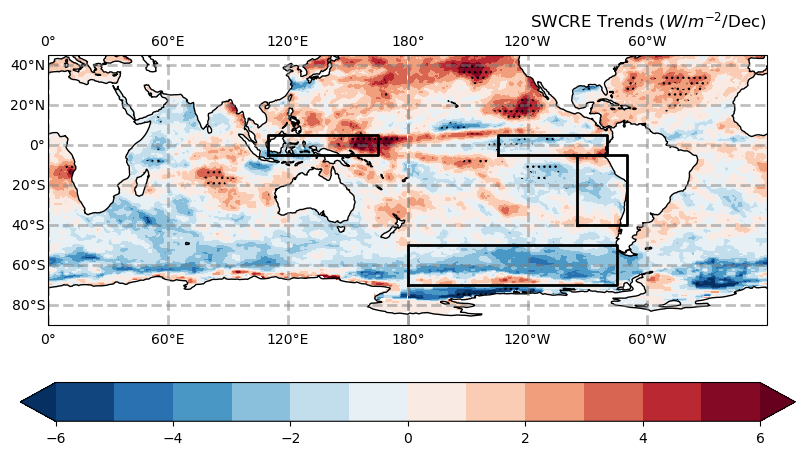

In [40]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
swas = remove_land(ceres, var="toa_sw_all_mon")
swcs = remove_land(ceres, var="toa_sw_clr_c_mon")
swcre = swcs - swas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(swcre.time)), dims=("time"))
swcre_trends = xscore.linslope(time_idx, swcre, dim="time")*12*10
swcre_sig = xscore.pearson_r_p_value(time_idx, swcre, dim="time")

# Plot ERA5 SST Trends
global_plot(swcre_trends, swcre_trends.lon, swcre_trends.lat, pvalues=swcre_sig, levels=np.arange(-6, 7, 1), cmap="RdBu_r", right_title=r"SWCRE Trends ($W/m^{-2}$/Dec)")

2023-08-07 10:52:50,477 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


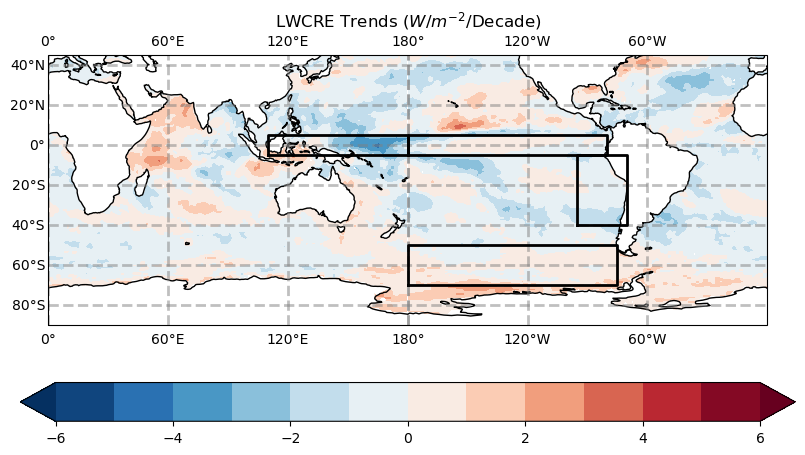

In [49]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
lwas = remove_land(ceres, var="toa_lw_all_mon")
lwcs = remove_land(ceres, var="toa_lw_clr_c_mon")
lwcre = lwcs - lwas # Clear Sky minus All Sky

time_idx = xr.DataArray(np.arange(len(lwcre.time)), dims=("time"))
lwcre_trends = xscore.linslope(time_idx, lwcre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(lwcre_trends, lwcre_trends.lon, lwcre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", title=r"LWCRE Trends ($W/m^{-2}$/Decade)")

2023-08-07 16:31:44,910 [WARNING]: dataset.py(decode_time:341) >> 'time' does not have a calendar attribute set. Defaulting to CF 'standard' calendar.


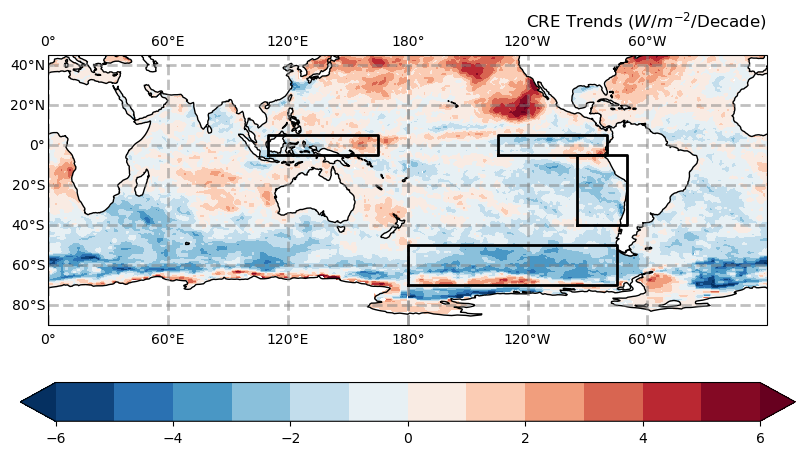

In [101]:
ceres = xc.open_dataset("data/obs/CERES_EBAF-TOA_Ed4.1_Subset_200003-202201.nc")
nas = remove_land(ceres, var="toa_net_all_mon")
ncs = remove_land(ceres, var="toa_net_clr_c_mon")
cre = -(ncs - nas) # Clear Sky minus All Sky (These are both incoming/downard fluxes, so we need to flip the sign)

time_idx = xr.DataArray(np.arange(len(cre.time)), dims=("time"))
cre_trends = xscore.linslope(time_idx, cre, dim="time")*12*10

# Plot ERA5 SST Trends
global_plot(cre_trends, cre_trends.lon, cre_trends.lat, levels=np.arange(-6, 7, 1), cmap="RdBu_r", right_title=r"CRE Trends ($W/m^{-2}$/Decade)")

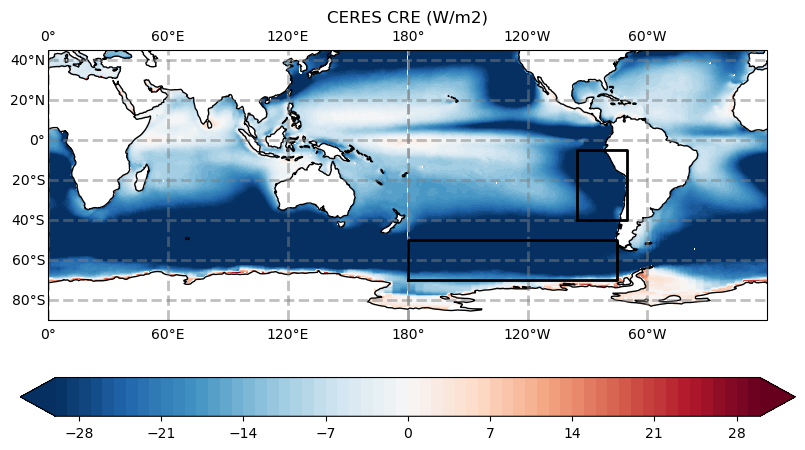

In [39]:
global_plot(cre.mean("time"), cre.lon, cre.lat, levels=np.arange(-30, 31, 1), cmap="RdBu_r", title="CERES CRE (W/m2)")

# Plot EIS Trends

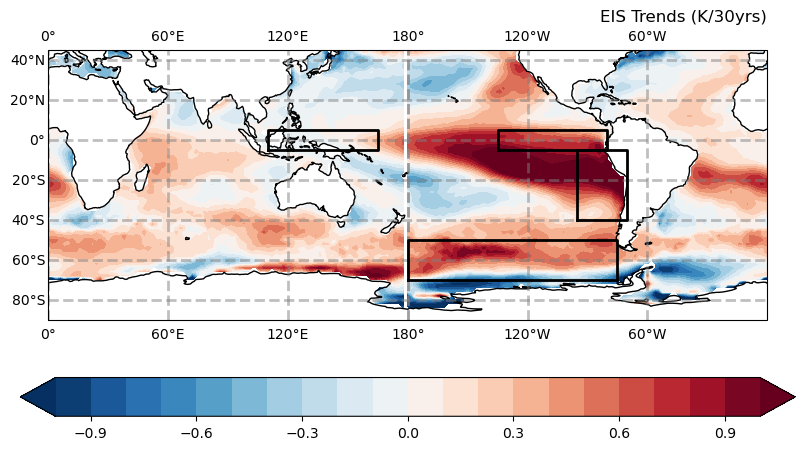

In [12]:
eis = xc.open_dataset("data/obs/EIS_mon_197901-202212_obs.nc")
eis = remove_land_full(eis, var="eis")

time_idx = xr.DataArray(np.arange(len(eis.time)), dims=("time"))
eis_trends = xscore.linslope(time_idx, eis, dim="time")*12*30

# Plot ERA5 SST Trends
global_plot(eis_trends, eis_trends.longitude, eis_trends.latitude, levels=np.arange(-1,1.1,.1), cmap="RdBu_r", right_title="EIS Trends (K/30yrs)")

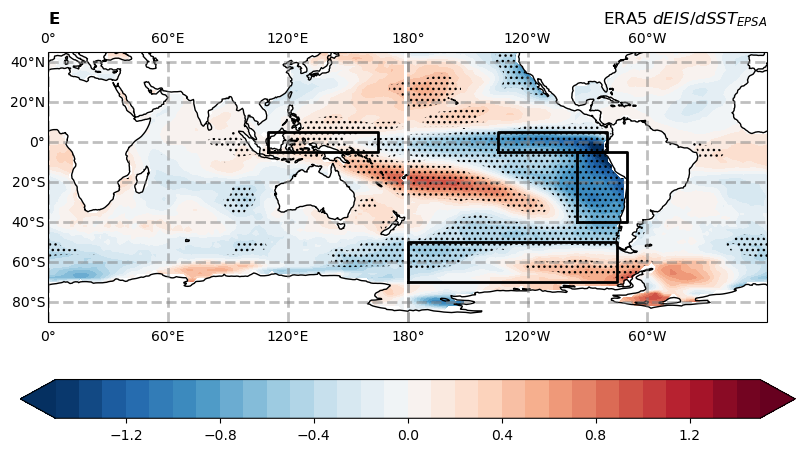

In [14]:
deis_dsstWE = xscore.linslope(era5_eastPacificSA, eis, dim="time", skipna=True)
deis_dsstWE_pvalue = xscore.pearson_r_p_value(era5_eastPacificSA, eis,dim="time", skipna=True)
global_plot(deis_dsstWE, deis_dsstWE.longitude, deis_dsstWE.latitude, pvalues=deis_dsstWE_pvalue, levels=np.arange(-1.5,1.6, .1), cmap="RdBu_r", left_title="E", right_title=r"ERA5 $dEIS/dSST_{EPSA}$")

# Plot dsst/dcre

In [41]:
cre = swcre
# era5_WE = era5_eastPacificSA

def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

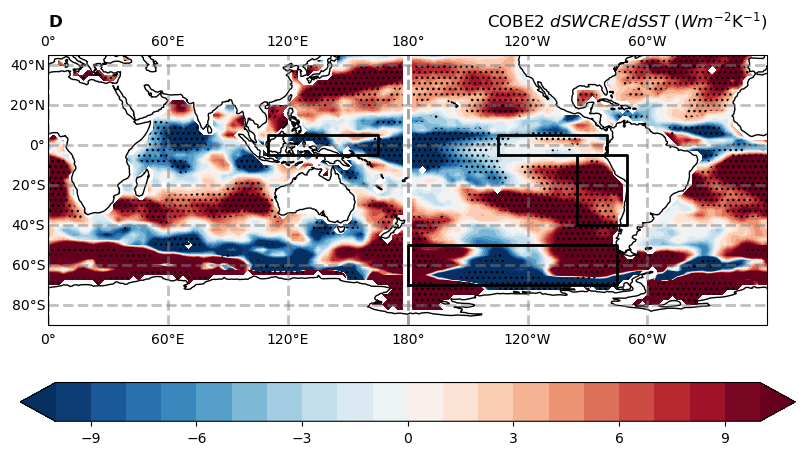

In [207]:
# lat = np.arange(-88.75, 90, 2.5)
# lon = np.arange(-178.75, 180, 2.5)
lat = np.arange(-90, 90, 2.5)
lon = np.arange(-180, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

# Regrid Data
era5_reindex = era5_ds.reindex(latitude=list(reversed(era5.latitude)))
era5_regrid = era5_ds.regridder.horizontal("skt", output_grid, tool='xesmf', method='bilinear')
cre_ds = fix_coords(cre.rename("cre").to_dataset())
cre_regrid = cre_ds.regridder.horizontal("cre", output_grid, tool='xesmf', method='bilinear')

# cre_regrid["time"] = np.arange("2000-03", "2022-02", dtype="datetime64[M]")
cre_regrid = cre_regrid.sel(time=slice("2000-03", "2019-12"))
cre_regrid["time"] = np.arange("2000-03", "2020-01", dtype="datetime64[M]")
era5_regrid = era5_regrid.sel(time=cre_regrid.time)
era5_regrid["time"] = cre_regrid.time

dcredsst = xscore.linslope(era5_regrid["skt"], cre_regrid["cre"], dim="time", skipna=True)
dcredsst_pvalue = xscore.pearson_r_p_value(era5_regrid["skt"], cre_regrid["cre"], dim='time', skipna=True)

global_plot(dcredsst, dcredsst.lon, dcredsst.lat, levels=np.arange(-10, 11, 1), pvalues=dcredsst_pvalue, cmap="RdBu_r", left_title="D", right_title=r"COBE2 $dSWCRE/dSST$ ($Wm^{-2}$K$^{-1}$)")

In [42]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data
    
# ds = fix_coords(dcredsst.rename("swcf").to_dataset())
# ds.sel(lon=slice(-95, -70), lat=slice(-40,-5)).spatial.average("swcf")["swcf"] # Observed definition 

In [43]:
cre["time"] = np.arange("2000-03", "2022-02", dtype="datetime64[M]")
era5_eastPacificSA = era5_eastPacificSA.sel(time=cre.time)
era5_eastPacificSA["time"] = cre.time

# cre = cre.resample(time="6M").mean()
# era5_WE_c = era5_WE_c.resample(time="6M").mean()
# dsstwedcre = xscore.linslope(cre, era5_WE_c, dim="time", skipna=True)

# Standardize
# cre = (cre - cre.mean("time")) / cre.std("time")
# era5_WE_c = (era5_WE_c - era5_WE_c.mean("time")) / era5_WE_c.std("time")

dsstwedcre = xscore.linslope(era5_eastPacificSA, cre, dim="time", skipna=True)
dsstwedcre_p = xscore.pearson_r_p_value(era5_eastPacificSA, cre, dim='time', skipna=True)
dsstwedcre = fix_coords(dsstwedcre.rename("fb").to_dataset())
dsstwedcre_p = fix_coords(dsstwedcre_p.rename("fb").to_dataset())

lat = np.arange(-88.75, 90, 2.5)
lon = np.arange(-178.75, 180, 2.5)
output_grid = xc.create_grid(lat, lon)

# Regrid Data
dsstwedcre = dsstwedcre.regridder.horizontal("fb", output_grid, tool='xesmf', method='bilinear')["fb"]
dsstwedcre_p = dsstwedcre_p.regridder.horizontal("fb", output_grid, tool='xesmf', method='bilinear')["fb"]

2023-08-09 09:33:36,375 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.
2023-08-09 09:33:36,404 [WARNING]: bounds.py(_create_bounds:398) >> The 'lat' coordinate variable is missing a 'units' attribute. Assuming 'units' is 'degrees_north'.


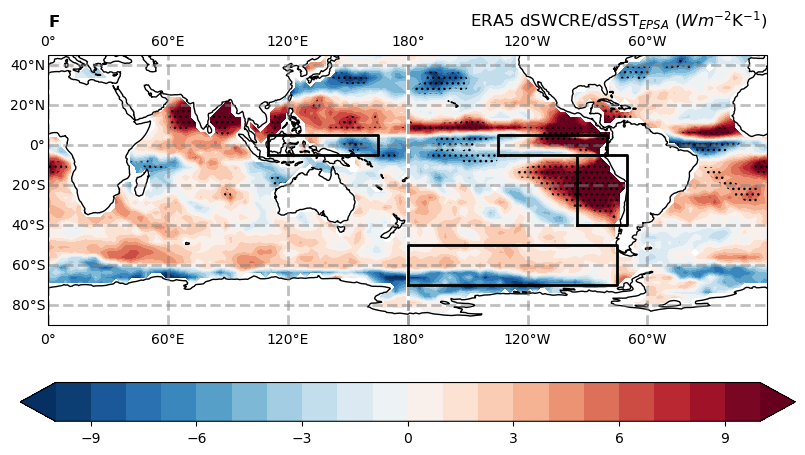

In [44]:
# global_plot(dsstwedcre, dsstwedcre.lon, dsstwedcre.lat, levels=np.arange(-.05, .055, .005), cmap="RdBu_r", title=r"Obs dSST$_{WE}$/dCRE (K/W/m2)")
global_plot(dsstwedcre, dsstwedcre.lon, dsstwedcre.lat, levels=np.arange(-10, 11, 1), pvalues=dsstwedcre_p, cmap="RdBu_r", left_title="F", right_title=r"ERA5 dSWCRE/dSST$_{EPSA}$ ($Wm^{-2}$K$^{-1}$)")

In [33]:
ds = fix_coords(dsstwedcre.to_dataset())
# westFB = ds.sel(lon=slice(-180, -125), lat=slice(-10,10)).spatial.average("fb")["fb"] # Observed definition 
# eastFB = ds.sel(lon=slice(-120, -70), lat=slice(-10, 10)).spatial.average("fb")["fb"] # Observed definition 

westFB = ds.sel(lon=slice(140, 180), lat=slice(-5,5)).spatial.average("fb")["fb"] # Observed definition 
eastFB = ds.sel(lon=slice(-110, -75), lat=slice(-30, 15)).spatial.average("fb")["fb"] # Observed definition 
eastFB = ds.sel(lon=slice(-110, -75), lat=slice(-30, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB - eastFB
# westFB
eastFB


<xarray.DataArray 'fb' ()>
array(6.49866635)
Attributes:
    regrid_method:  bilinear

In [110]:
eastFB = ds.sel(lon=slice(-120, -80), lat=slice(-20, 10)).spatial.average("fb")["fb"] # Observed definition 
westFB = ds.sel(lon=slice(140, 180), lat=slice(-5, 5)).spatial.average("fb")["fb"] # Observed definition 
westFB - eastFB
eastFB

<xarray.DataArray 'fb' ()>
array(-0.01325601)
Attributes:
    regrid_method:  bilinear